In [31]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import dlib
%matplotlib inline 

- All images used in the project are from Generated Photos(https://drive.google.com/drive/folders/1GKEK_gQ7xKiQJnmYnsJdkyVvM0WNjZ8g)

#### 1  Correspondence

In [34]:
# use dlib to detect face landmarks
def  landmark_detect(img_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    gary_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    face_boxes = detector(gary_img,1) 
    faces_landmarks_lst = [] 
    for face in face_boxes:
        shape = predictor(gary_img, face)
        landmarks_lst = []
        for idx, point in enumerate(shape.parts()):
            faces_landmarks_lst.append((point.x,point.y))
    # manually add 8 points 
    #The point in the upper left corner of the image
    faces_landmarks_lst.append((0,0))
    #The point in the middle of the left border
    faces_landmarks_lst.append((0,gary_img.shape[0]//2))
    #Lower left corner
    faces_landmarks_lst.append((0,gary_img.shape[0]-1))
    #Point in the middle of the upper border
    faces_landmarks_lst.append((gary_img.shape[1]//2,0))
    #The point in the middle of the lower border
    faces_landmarks_lst.append((gary_img.shape[1]//2,gary_img.shape[0]-1))
    #Upper right corner
    faces_landmarks_lst.append((gary_img.shape[1]-1,0))
    #Point in the middle of the right border
    faces_landmarks_lst.append((gary_img.shape[1]-1,gary_img.shape[0]//2))
    #Lower right corner
    faces_landmarks_lst.append((gary_img.shape[1]-1,gary_img.shape[0]-1))

    return faces_landmarks_lst

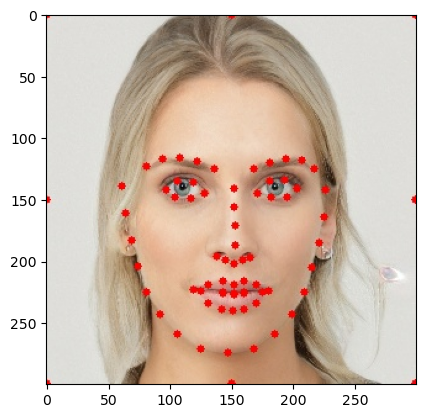

In [30]:
img_path = "pic1.jpg"
img = cv2.imread(img_path)
faces_landmarks_lst = landmark_detect(img_path)
for face in [faces_landmarks_lst]:
    for points in face:
            cv2.circle(img, points, 3, (0, 0, 255), -1)  
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img, '', points, font, 0.3, (255, 0, 0), 1, cv2.LINE_AA)

cv2.namedWindow("correspondence", cv2.WINDOW_NORMAL)
cv2.imwrite("correspondence.jpg", img)
img1 = cv2.imread("correspondence.jpg")
# cv2.imshow("correspondence", img)
# cv2.waitKey(1)
# cv2.destroyAllWindows()
plt.figure()
plt.imshow(img1[:,:,[2,1,0]])
plt.show()

#### 2  Mesh

- Create a triangulation (10 points) and visualise it (10 points).

In [6]:
# def create_triangulation1(points_list,img):
#     # use Subdiv2D to create a Delaunay triangulation
#     #img = cv2.imread(img_path)
#     size = img.shape 
#     rect = (0, 0, size[1], size[0])	
#     # Create an instance of Subdiv2D with the rectangle defined above
#     subdiv  = cv2.Subdiv2D(rect)
#     #Insert points into subdiv
#     for point in points_list:
#         subdiv.insert(point)
#     tri_vertices_lst = subdiv.getTriangleList()
#     lst = []
#     for tri in tri_vertices_lst:
#         p1 = (int(tri[0]),int(tri[1]))
#         p2 = (int(tri[2]),int(tri[3]))
#         p3 = (int(tri[4]),int(tri[5]))
#         lst.append([p1,p2,p3])
#     return tri_vertices_lst,lst
    
from scipy.spatial import Delaunay
def create_triangulation(points_list):
    return Delaunay(points_list).simplices # shape: 



# def visualise1(tri_vertices_lst,img):
#     for tri in tri_vertices_lst:
#         p1 = (int(tri[0]),int(tri[1]))
#         p2 = (int(tri[2]),int(tri[3]))
#         p3 = (int(tri[4]),int(tri[5]))
#         delaunay_color = (0, 0, 255)
#         # draw lines on the image
#         cv2.line(img,p1,p2,delaunay_color,1,cv2.LINE_AA, 0)
#         cv2.line(img,p2,p3,delaunay_color,1,cv2.LINE_AA, 0)
#         cv2.line(img,p3,p1,delaunay_color,1,cv2.LINE_AA, 0)


def visualise(tri_vertices_lst,faces_landmarks_lst,img):
    for tri in tri_vertices_lst:
        p1 = faces_landmarks_lst[tri[0]]
        p2 = faces_landmarks_lst[tri[1]]
        p3 = faces_landmarks_lst[tri[2]]
        delaunay_color = (0, 0, 255)
        # draw lines on the image
        cv2.line(img,p1,p2,delaunay_color,1,cv2.LINE_AA, 0)
        cv2.line(img,p2,p3,delaunay_color,1,cv2.LINE_AA, 0)
        cv2.line(img,p3,p1,delaunay_color,1,cv2.LINE_AA, 0)

    

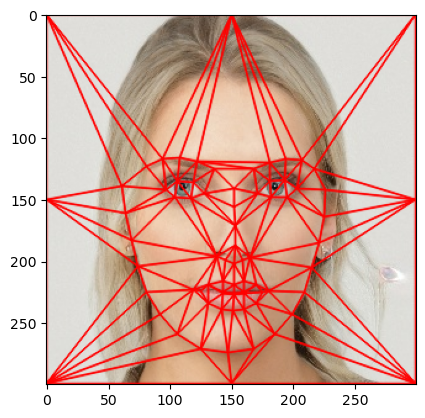

In [7]:
# visualization
img2 = cv2.imread("pic1.jpg")
faces_landmarks_lst = landmark_detect("pic1.jpg")
tri_vertices_lst = create_triangulation(faces_landmarks_lst)
visualise(tri_vertices_lst,faces_landmarks_lst,img2)
# cv2.imshow("win_delaunary_triangulation",img)
# cv2.waitKey(100)
plt.figure()
plt.imshow(img2[:,:,[2,1,0]])
plt.show()

#### 3 Blending with a mesh  

In [9]:

# this function calculate the affine transformations matrix by taking the pair of corresponding triangles
def get_affine_warp(source_tri,target_tri):
    '''
    input:  the 3 pairs of corresponding vertices
    output: 3x3 matrix T

    ''' 
    source_matrix = np.zeros((3,3),dtype=float)
    target_matrix = np.zeros((3,3),dtype=float)
    source_matrix[:,2] = 1
    target_matrix[:,2] = 1
    T = np.zeros((3,3),dtype=float)
    for i in range(3):
        source_matrix[i,0:2] = source_tri[i]
        target_matrix[i,0:2] = target_tri[i]
    source_matrix = source_matrix.transpose()
    target_matrix = target_matrix.transpose()
    T = target_matrix.dot(np.linalg.pinv(source_matrix))
    return T

def inverse_warp(T,point):
    p = np.array([point[0],point[1], 1], np.float32)
    source_point = np.dot(T, p)
    return source_point

import math
def BiLinear_interpolation(img,float_x,float_y):
    x = np.asarray(float_x)
    y = np.asarray(float_y)

    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    x1 = x0 + 1
    y1 = y0 + 1

    if(x1>=img.shape[0] or y1>=img.shape[1]):
        A = np.array([[[255,255,255]]])
        B = np.array([[[255,255,255]]])
        C = np.array([[[255,255,255]]])
        D = np.array([[[255,255,255]]])
    else:
        A = img[y0, x0]
        B = img[y1, x0]
        C = img[y0, x1]
        D = img[y1, x1]
    return (x1-x) * (y1-y)*A + (x1-x) * (y-y0)*B + (x-x0) * (y1-y)*C + (x-x0) * (y-y0)*D


# determine whether the point is inside the triangle
from matplotlib import path

def isInTriangle(point,tri):
    p = path.Path(tri)
    return p.contains_points([point])[0]

def get_bounding_rect(tri):
    p1 = [[tri[0][0],tri[0][1]]]
    p2 = [[tri[1][0],tri[1][1]]]
    p3 = [[tri[2][0],tri[2][1]]]
   
    p = np.array([p1, p2,p3], np.float32)
    x,y,w,h  = cv2.boundingRect(p)
    return x,y,w,h

def mesh_morphing(w,start_path,end_path):
    start_img = cv2.imread(start_path)
    end_img = cv2.imread(end_path)
    start_landmarks = landmark_detect(start_path)
    end_landmarks = landmark_detect(end_path)
    inter_landmarks = (1 - w) * np.array(start_landmarks) + w * np.array(end_landmarks)
    inter_triangles_idx = create_triangulation(inter_landmarks)
    inter_img = np.zeros(start_img.shape, dtype=np.uint8)
    for idx, tri in enumerate(inter_triangles_idx):
        a = tri[0]
        b = tri[1]
        c = tri[2]
        inter_triangles = [inter_landmarks[a], inter_landmarks[b], inter_landmarks[c]]
        start_triangles = [start_landmarks[a], start_landmarks[b], start_landmarks[c]]
        end_triangles = [end_landmarks[a], end_landmarks[b], end_landmarks[c]]
        # start_T = get_affine_warp(start_triangles,inter_triangles)[0:2,:]
        # end_T = get_affine_warp(end_triangles,inter_triangles)[0:2,:]
        start_T = get_affine_warp(inter_triangles,start_triangles)[0:2,:]
        end_T = get_affine_warp(inter_triangles,end_triangles)[0:2,:]
        rect_x,rect_y,rect_w,rect_h = get_bounding_rect(inter_triangles)
        for x in range(rect_x,rect_x+rect_w):
            for y in range(rect_y,rect_y+rect_h):
                if isInTriangle((x,y),inter_triangles):
                    start_p = inverse_warp(start_T,(x,y))
                    end_p = inverse_warp(end_T,(x,y))
                    start_pixel = BiLinear_interpolation(start_img,start_p[0],start_p[1])
                    end_pixel = BiLinear_interpolation(end_img,end_p[0],end_p[1])
                    pixel = (1-w)*start_pixel+w*end_pixel
                    pixel = pixel.reshape(1,1,3)
                    inter_img[y,x,:] = pixel
    return inter_img


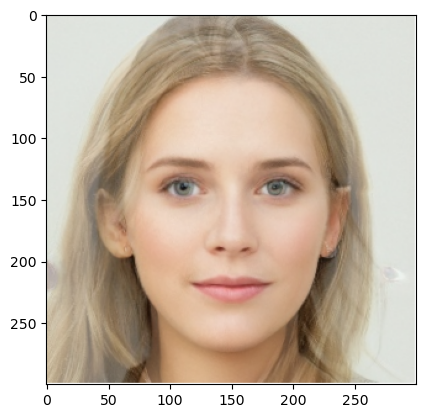

In [11]:
img3 = mesh_morphing(0.5,"pic1.jpg","pic2.jpg")
img3 = np.clip(img3, 0, 255)
img3 = img3.astype(np.uint8)
plt.figure()
plt.imshow(img3[:,:,[2,1,0]])
plt.show()
# cv2.imshow("inter", inter)
# cv2.waitKey(1)
# cv2.destroyAllWindows()


#### 4  Blending without a mesh

In [44]:
''' 
This was adapted from github:
https://github.com/Jarvis73/Moving-Least-Squares/blob/master/img_utils.py
@author: Jian-Wei ZHANG
'''

def precompute(s,image,landmarks_num):
    '''
    s: source points
    image: the source image
    landmarks_num: the number of correspondences
    '''
    # build a contiguous array to make compute fast
    s = np.ascontiguousarray(s.astype(np.int16))
    alpha=1.0
     
    reshaped_s = s.reshape(landmarks_num, 2, 1, 1)
    h, w = image.shape[0],image.shape[1]
    gridX = np.arange(w, dtype=np.int16)
    gridY = np.arange(h, dtype=np.int16)
    Xy, Xx = np.meshgrid(gridX, gridY)
    grow,gcol = Xx.shape[0],Xx.shape[1]  
    reshaped_X = np.vstack((Xx.reshape(1, grow, gcol), Xy.reshape(1, grow, gcol)))
    # kappa(d) = 1/d^(2a) ,  reshaped_s: X_s,i , reshaped_X: X
    k = 1.0 / (np.sum((reshaped_s - reshaped_X).astype(np.float32) ** 2, axis=1) + 1e-8) ** alpha    
    # k_i/sum(k_i)
    k /= np.sum(k, axis=0, keepdims=True)      
    s_star = np.zeros((2, grow, gcol), np.float32)
    # s_star = sum(k_i*s_i)/sum(k_i)
    for i in range(landmarks_num):
        s_star += k[i] * reshaped_s[i]  
    s_hat = reshaped_s - s_star
    s_hat = s_hat.reshape(landmarks_num, 2, 1, grow, gcol)                                       
    s_hat1 = s_hat.reshape(landmarks_num, 1, 2, grow, gcol)                                       
    reshaped_k = k.reshape(landmarks_num, 1, 1, grow, gcol)                                 
    sTks = np.zeros((2, 2, grow, gcol), np.float32)
    for i in range(landmarks_num):
        sTks += s_hat[i] * reshaped_k[i] * s_hat1[i]
    del s_hat1
    inv_sTks = np.linalg.inv(sTks.transpose(2, 3, 0, 1))    
    return Xx,Xy,grow, gcol,k,reshaped_k,s_star,reshaped_X,s_hat,inv_sTks

def calculateTarget(t,landmarks_num,grow, gcol,k):
    ''' 
    t: target points 
    k: k_i/sum(k_i)
    '''
    t = np.ascontiguousarray(t.astype(np.int16))
    reshaped_t = t.reshape((landmarks_num, 2, 1, 1))                                       
    t_star = np.zeros((2, grow, gcol), np.float32)
    for i in range(landmarks_num):
        #t_star = sum(k_i*t_i)/sum(k_i)
        t_star += k[i] * reshaped_t[i]            
    return reshaped_t,t_star

def deformation(image,s_landmarks,t_landmarks):
    landmarks_num = len(s_landmarks)
    s = np.zeros((landmarks_num,2))
    t = np.zeros((landmarks_num,2))
    for i in range(landmarks_num):
        s[i] = s_landmarks[i]
        t[i] = t_landmarks[i]
    Xx,Xy,grow,gcol,k,reshaped_k,s_star,reshaped_X,s_hat,inv_sTks = precompute(s,image,landmarks_num)
    # A_j = (X-s*)()^(-1)k_js_jT
    first_term = reshaped_X - s_star                                                       
    reshaped_first_term = first_term.reshape(1, 2, grow, gcol).transpose(2, 3, 0, 1)        
    third_term = np.multiply(reshaped_k, s_hat, out=s_hat)                                 
    reshaped_third_term = third_term.transpose(0, 3, 4, 1, 2)                             
    out_A = third_term.reshape(2, landmarks_num, grow, gcol, 1, 1)[0]                            
    A = np.matmul(np.matmul(reshaped_first_term, inv_sTks), reshaped_third_term, out=out_A)   
    A = A.reshape(landmarks_num, 1, grow, gcol)                                                
    del third_term, reshaped_third_term, s_hat
    reshaped_t,t_star = calculateTarget(t,landmarks_num,grow, gcol,k)
    del k, reshaped_k
    f = np.zeros((2, grow, gcol), np.float32)
    for i in range(landmarks_num):
        # f_affine(X) = sum(A*vector_t) + t_star
        f += A[i] * (reshaped_t[i] - t_star)
    # + t_star
    f += t_star
    del A
    f[f < 0] = 0
    f[0][f[0] > grow - 1] = 0
    f[1][f[1] > gcol - 1] = 0
    affine = f.astype(np.int16)
    deformed_img = np.ones_like(image)
    deformed_img[Xx, Xy] = image[tuple(affine)]
    return deformed_img

def create_deformed_image(w,start_path,end_path):
    start_img = cv2.imread(start_path)
    end_img = cv2.imread(end_path)
    start_landmarks = landmark_detect(start_path)
    end_landmarks = landmark_detect(end_path)
    inter_landmarks = (1 - w) * np.array(start_landmarks) + w * np.array(end_landmarks)
    img1 = deformation(start_img, inter_landmarks, start_landmarks)
    img2 = deformation(end_img, end_landmarks, inter_landmarks)
    img3 = (1-w) * img1 + w * img2
    return img3

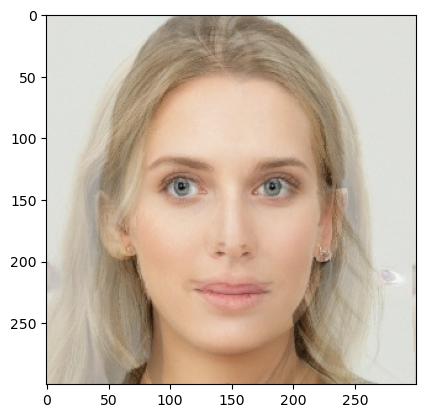

In [45]:

img4 = create_deformed_image(0.3,"pic1.jpg","pic2.jpg")
img4 = np.clip(img4, 0, 255)
img4 = img4.astype(np.uint8)
plt.figure()
plt.imshow(img4[:,:,[2,1,0]])
plt.show()
# cv2.imshow("blending without a mesh", img3)
# cv2.waitKey(1)
# cv2.destroyAllWindows()

#### 5 Capture

In [41]:
# save images from the meshed method
def save_morphing_images(save_path,start_path,end_path):
    w_list=np.linspace(0,1,num=10)
    for idx,w in enumerate(w_list):
        morphing_img = mesh_morphing(w,start_path,end_path)
        cv2.imwrite(save_path+"{}.jpg".format(str(idx+1)),morphing_img)

# save images from the meshless method
def save_deformed_images(save_path,start_path,end_path):
    w_list=np.linspace(0,1,num=10)
    for idx,w in enumerate(w_list):
        morphing_img = create_deformed_image(w,start_path,end_path)
        cv2.imwrite(save_path+"{}.jpg".format(str(idx+1)),morphing_img)

 


In [27]:
save_morphing_images("./meshed_images/","pic1.jpg","pic2.jpg")
save_deformed_images("./meshless_images/","pic1.jpg","pic2.jpg")


In [19]:
def createVideo(h,w,video_path,image_file):
    fps=10
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_path, fourcc, fps, (w,h))
    for i in range(10):
        file_name = image_file + str(i+1) +".jpg"
        image=cv2.imread(file_name)
        video.write(image)  

In [28]:
img = cv2.imread("pic1.jpg")
h = img.shape[0]
w = img.shape[1]
createVideo(h,w,'./meshed_video.mp4',"./meshed_images/")
createVideo(h,w,'./mesheless_video.mp4',"./meshless_images/")